# Analysis of career transitions



# 0. Import dependencies and inputs

In [2]:
%run ../notebook_preamble_Transitions.ipy
import os

data = load_data.Data()

In [10]:
np.where(data.node_to_essential_items.items_list.apply(lambda x: len(x))==0)

(array([1959]),)

In [289]:
# from itertools import combinations
# from scipy.spatial.distance import pdist, squareform
# import warnings
# from scipy.stats import ks_2samp, mannwhitneyu, spearmanr, kruskal

In [290]:
# # Data
# data = load_data.Data()
# sim = load_data.Similarities()

# # Rename risk categories
# data.occ_top['risk_cat_label_Old'] = data.occ_top['risk_cat_label'].copy()
# data.occ_top.loc[
#     data.occ_top.risk_cat_label.isin(['Low risk', 'Hidden risk', 'Hidden protection', 'High risk']), 'risk_cat_label'
# ] = 'Lower risk'
# data.occ_top.loc[
#     data.occ_top.risk_cat_label.isin(['Very low risk']), 'risk_cat_label'
# ] = 'Lower risk'
# data.occ_top.loc[
#     data.occ_top.risk_cat_label.isin(['Very high risk']), 'risk_cat_label'
# ] = 'High risk'

# # Paths
# data_folder = '../../data/'
# outputs_folder = '../../reports/outputs/transitions_outputs/'
# figure_folder = '../../reports/outputs/output_figures/'

# # Load all possible transitions dataframe
# transitions = pd.read_csv(outputs_folder + 'transitions_all_occupations.csv')

## 0.1 Generate 'filtering' matrices

In [3]:
file_name = 'filter_matrices_Report_occupations.pickle'
export_path = f'{data_folder}interim/transitions/{file_name}'

if os.path.exists(export_path):
    filter_matrices = pickle.load(open(export_path,'rb'))
    print(f'Imported filtering matrices from {export_path}')
else:
    # May take about 30 mins
    filter_matrices = trans_utils.create_filtering_matrices(
        origin_ids='report', 
        destination_ids= 'report',
        export_path = export_path)

Imported filtering matrices from /Users/karliskanders/Documents/mapping-career-causeways/codebase/data/interim/transitions/filter_matrices_Report_occupations.pickle


In [4]:
# All the different filtering matrices, and the identities of their rows (rows='origin_ids' & cols='destination_ids')
for key in filter_matrices.keys():
    print(key)

F_viable
F_min_viable
F_highly_viable
F_desirable
F_jobzone
F_earnings
F_not_high_risk
F_safer
F_strictly_safe
F_not_self
F_safe_desirable
F_strictly_safe_desirable
origin_ids
destination_ids


# 1. Calculate the number of transitions for each occupations

## 1.1 Number of desirable transitions

First, we assess transitions that are desirable, meaning that they are both viable (sufficiently good fit in terms of skills, work activities and work context) and do not incure a major salary loss.


In [77]:
# Desirable transitions
n_desirable = np.sum(filter_matrices['F_desirable'], axis=1)

# Highly viable, desirable transitions
n_desirable_and_highly_viable = np.sum(
    (filter_matrices['F_desirable'] & filter_matrices['F_highly_viable']), axis=1)

## 1.2 Number of safe and desirable transitions (default condition)

We use the default criteria for safe transitions - that safe destination is defined as not being 'high risk'. We use these results to compare 'high risk' versus 'lower risk' occupations ('lower risk' occupations belonging to the 'other' or 'low risk' categories).

In [78]:
# Safe and desirable transitions
n_safe_desirable = np.sum(filter_matrices['F_safe_desirable'], axis=1)

# Highly viable, safe and desirable transitions
n_safe_desirable_and_highly_viable = np.sum(
    (filter_matrices['F_safe_desirable'] & filter_matrices['F_highly_viable']), axis=1)


## 1.3 Number of safe and desirable transitions (strict condition)

We use the more stricter criteria for defining safe transitions when making comparisons solely between 'high risk' occupations.

In [79]:
# Strictly safer and desirable transitions
n_safe_desirable_strict = np.sum(filter_matrices['F_strictly_safe_desirable'], axis=1)

# Highly viable, strictly safe
n_safe_desirable_strict_and_highly_viable = np.sum(
    (filter_matrices['F_strictly_safe_desirable'] & filter_matrices['F_highly_viable']), axis=1)


## 1.4 Export the transition option results

In [88]:
occ_transitions = data.occ_report[['id', 'concept_uri', 'preferred_label', 'isco_level_4', 'risk_category']].copy()
occ_transitions['n_desirable'] = n_desirable
occ_transitions['n_desirable_and_highly_viable'] = n_desirable_and_highly_viable
occ_transitions['n_safe_desirable'] = n_safe_desirable
occ_transitions['n_safe_desirable_and_highly_viable'] = n_safe_desirable_and_highly_viable
occ_transitions['n_safe_desirable_strict'] = n_safe_desirable_strict
occ_transitions['n_safe_desirable_strict_and_highly_viable'] = n_safe_desirable_strict_and_highly_viable

In [ ]:
occ_transitions.to_csv(XXX)

# 2. Analysis of transition options

## 2.1 Set up helper functions

In [295]:
def merge_risks(base_df, id_col, risk_col_label):
    """
    Add risk info to the dataframe
    """
    trans_risk = base_df.merge(data.occ_top[['id','risk','prop_bottleneck_tasks','risk_cat_label']],
                               left_on=id_col, right_on='id', how='left').rename(
        columns={
            'risk': risk_col_label+'_risk',
            'prop_bottleneck_tasks': risk_col_label+'_prop',
            'risk_cat_label': risk_col_label+'_risk_cat'
        })    
    return trans_risk

# TODO - update for using filtering matrices

# Plot cumulative distributions
def plot_cum_dist(trans, col_name):
    
    warnings.simplefilter("ignore")

    for j, cat in enumerate(risk_cat):
        x = trans[trans.origin_id.isin(cat_ids[j])][col_name]
        x_sorted = np.sort(x)
        p = np.array(list(range(0,len(x_sorted)))) / len(x_sorted)
        sns.lineplot(y=p, x=x_sorted, label=risk_cat[j], color=color_pal_[j], linewidth=1.75)    

    warnings.simplefilter("default")

def plot_cum_dist_F(F):
    
    warnings.simplefilter("ignore")

    for j, cat in enumerate(risk_cat):
        x = np.sum(F[[data.id_to_top_id[x] for x in cat_ids[j]],:], axis=1)
        x_sorted = np.sort(x)
        p = np.array(list(range(0,len(x_sorted)))) / len(x_sorted)
        sns.lineplot(y=p, x=x_sorted, label=risk_cat[j], color=color_pal_[j], linewidth=1.75)    

    warnings.simplefilter("default")    
    
# KS statistic and p-values
def get_ks_stat(trans, col_name):
    KS = np.zeros((len(risk_cat),len(risk_cat)))
    P = np.zeros((len(risk_cat),len(risk_cat)))
    for i, cat in enumerate(risk_cat):
        for j, cat in enumerate(risk_cat):
            ks = ks_2samp(
                trans[trans.origin_id.isin(cat_ids[i])][col_name],
                trans[trans.origin_id.isin(cat_ids[j])][col_name])
            KS[i][j] = ks.statistic
            P[i][j] = ks.pvalue
    return KS, P

def get_ks_stat_F(F, col_name):
    KS = np.zeros((len(risk_cat),len(risk_cat)))
    P = np.zeros((len(risk_cat),len(risk_cat)))
    for i, cat in enumerate(risk_cat):
        for j, cat in enumerate(risk_cat):
            x_1 = np.sum(F[[data.id_to_top_id[x] for x in cat_ids[i]],:], axis=1)
            x_2 = np.sum(F[[data.id_to_top_id[x] for x in cat_ids[j]],:], axis=1)
            ks = ks_2samp(
                x_1,
                x_2)
            KS[i][j] = ks.statistic
            P[i][j] = ks.pvalue
    return KS, P
            
def plot_ks_matrix(KS):
    f, ax = plt.subplots(figsize=(4, 4))
    mask = np.triu(np.ones_like(KS, dtype=np.bool))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    ax = sns.heatmap(np.round(KS,2), annot=True,  cmap=cmap, mask=None, center=0, square=True)
    fix_heatmaps(ax)
    plt.xticks(ticks=np.array(list(range(len(risk_cat))))+0.5, labels=risk_cat, rotation=90)
    plt.yticks(ticks=np.array(list(range(len(risk_cat))))+0.5, labels=risk_cat, rotation=0)

def plot_pval_matrix(P): 
    f, ax = plt.subplots(figsize=(4, 4))
    mask = np.triu(np.ones_like(P, dtype=np.bool))
    cmap = sns.diverging_palette(10, 220, as_cmap=True)
    ax = sns.heatmap(np.round(P,2), annot=True,  cmap=cmap, mask=None,
                     center=0.05, vmin=0, vmax=1, square=True)
    fix_heatmaps(ax)
    plt.xticks(ticks=np.array(list(range(len(risk_cat))))+0.5, labels=risk_cat, rotation=90)
    plt.yticks(ticks=np.array(list(range(len(risk_cat))))+0.5, labels=risk_cat, rotation=0)

def check_MW(trans, col_name, i, j):
    print(f'{risk_cat[i]} vs. {risk_cat[j]}')
    return mannwhitneyu(
        trans[trans.origin_id.isin(cat_ids[i])][col_name],
        trans[trans.origin_id.isin(cat_ids[j])][col_name],
        alternative='two-sided'
    ) 

def check_MW_F(F, i, j):
    print(f'{risk_cat[i]} vs. {risk_cat[j]}')
    x_1 = np.sum(F[[data.id_to_top_id[x] for x in cat_ids[i]],:], axis=1)
    x_2 = np.sum(F[[data.id_to_top_id[x] for x in cat_ids[j]],:], axis=1)    
    return mannwhitneyu(
        x_1,
        x_2,
        alternative='two-sided'
    ) 

In [296]:
# Colors for visualisations
color_pal = ['#e6194b', '#3cb44b', '#4363d8', '#f58231',
             '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
             '#008080', '#e6beff', '#9a6324', '#800000', '#808000','#ffe119',
             '#aaffc3', '#000000', '#ffd8b1', '#808000', '#000075']

In [297]:
## Choose which risk categories to show in the graphs

# risk_cat = ['Very low risk', 'Low risk', 'Hidden risk', 'Hidden protection', 'High risk', 'Very high risk']
# risk_cat = ['Very low risk', 'Low risk', 'High risk', 'Very high risk']
# risk_cat = ['Low risk', 'Medium risk', 'High risk']
risk_cat = ['Lower risk', 'High risk']

cat_ids = [data.occ_top[data.occ_top.risk_cat_label==cat].id.to_list() for cat in risk_cat]

# Line colors
if len(risk_cat)==2:
    color_pal_ = [color_pal[j] for j in [2, 0] ]
if len(risk_cat)==3:
    color_pal_ = [color_pal[j] for j in [2, 3, 0] ]
if len(risk_cat)==4:
    color_pal_ = [color_pal[j] for j in [2, 1, 3, 0] ]
if len(risk_cat)==6:
    color_pal_ = [color_pal[j] for j in [2, 1, 4, 5, 3, 0] ]

## 0.1 Risk vs similarity

Quick check to see how occupation similarity and risk relate to each other

In [298]:
top_occ = data.occ_top[-data.occ_top.risk.isnull()].id.to_list()

In [299]:
W_combined = sim.W_combined.copy()
W_combined = W_combined[top_occ, :]
W_combined = W_combined[:, top_occ]
W_combined.shape

(1627, 1627)

In [300]:
# risk_dif_matrix = np.zeros(W_combined.shape)
# bottleneck_dif_matrix = np.zeros(W_combined.shape)

# for ii, occ_i in enumerate(tqdm(top_occ, total=len(top_occ))):
#     for jj, occ_j in enumerate(top_occ[ii:]):
#         risk_dif_matrix[ii][ii+jj] = data.occ_top.loc[occ_j].risk - data.occ_top.loc[occ_i].risk
#         bottleneck_dif_matrix[ii][ii+jj] = data.occ_top.loc[occ_j].prop_bottleneck_tasks - data.occ_top.loc[occ_i].prop_bottleneck_tasks
        

In [301]:
# np.save(data_folder + 'interim/risk_dif_matrix.npy', risk_dif_matrix)
# np.save(data_folder + 'interim/bottleneck_dif_matrix.npy', bottleneck_dif_matrix)

In [302]:
# np.load(data_folder + 'interim/risk_dif_matrix.npy', risk_dif_matrix)
# np.load(data_folder + 'interim/bottleneck_dif_matrix.npy', bottleneck_dif_matrix)

In [303]:
sns.scatterplot(x=W_combined.flatten(), y=np.abs(risk_dif_matrix + risk_dif_matrix.T).flatten(), alpha=0.1)

NameError: name 'risk_dif_matrix' is not defined

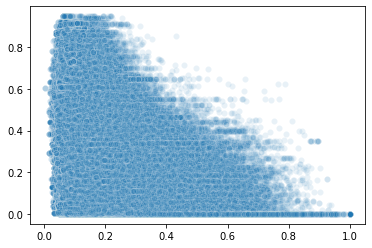

In [307]:
sns.scatterplot(x=W_combined.flatten(), y=np.abs(bottleneck_dif_matrix + bottleneck_dif_matrix.T).flatten(), alpha=0.1)

# 1. Viable & desirable destinations

Analysis of only the viable & desirable transitions (regardless of automation risk)

In [304]:
# Prepare a dataframe to save the results in
occ_n_transitions = data.occ_top.copy()
occ_n_transitions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1701 entries, 1 to 2941
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          1701 non-null   int64  
 1   concept_uri                 1701 non-null   object 
 2   preferred_label             1701 non-null   object 
 3   isco_level_4                1701 non-null   int64  
 4   onet_code                   1680 non-null   object 
 5   onet_title                  1680 non-null   object 
 6   risk                        1627 non-null   float64
 7   prop_bottleneck_tasks       1627 non-null   float64
 8   prop_phys_bottleneck_tasks  1627 non-null   float64
 9   risk_std                    1627 non-null   float64
 10  bottleneck_quartile         1627 non-null   float64
 11  risk_quartile               1627 non-null   float64
 12  risk_cat                    1627 non-null   float64
 13  risk_cat_label              1701 

In [305]:
## Select the relevant subset of transitions
trans_select = transitions[transitions.is_viable_desirable]


In [306]:
# Viable, desirable filtering matrices
F_v_ = filter_matrices['F_viable_desirable'] & filter_matrices['F_not_self'] #& filter_matrices['F_safer']
# jj = 1627 occupations that are being analysed (out of all the top occupations)
jj = [data.id_to_top_id[x] for x in data.occ_top[-data.occ_top.risk.isnull()].id.to_list()]
F_v = F_v_[:,jj]

# Highly viable, desirable filtering matrices 
F_hi_ = F_v_ & filter_matrices['F_highly_viable']
F_hi = F_hi_[:,jj]


In [307]:
assert(len(trans_select)==np.sum(F_v[jj,:]))

## 1.1 Number of transition options for different risk categories

### Distributions and moments

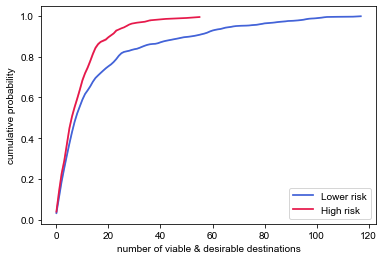

In [308]:
## Aggregate transition stats for each occupation

# # Plot cumulative distributions
plot_cum_dist_F(F_hi)
plt.legend(loc='lower right')
plt.xlabel('number of viable & desirable destinations')
plt.ylabel('cumulative probability')
plt.show()


In [309]:
# Row # for high risk
rows_high_risk = [data.id_to_top_id[x] for x in cat_ids[1]]
# Row # for lower risk
rows_lower_risk = [data.id_to_top_id[x] for x in cat_ids[0]]

# Transitions for each risk category
x_all = np.sum(F_v, axis=1)
x_lower_risk = np.sum(F_v[rows_lower_risk,:], axis=1)
x_high_risk = np.sum(F_v[rows_high_risk,:], axis=1)

In [310]:
# Check if there are occupations with zero transitions
np.where(x_lower_risk==0)

(array([ 154,  471,  507,  759,  901,  955,  983, 1144]),)

In [311]:
# Means
print(np.round(np.mean(x_lower_risk)), np.round(np.mean(x_high_risk)))
# Difference of means
print((np.mean(x_lower_risk)-np.mean(x_high_risk))/np.mean(x_high_risk))
print((np.mean(x_lower_risk)-np.mean(x_high_risk))/np.mean(x_lower_risk))

46.0 34.0
0.36013025698960566
0.2647763000190046


In [312]:
# Medians
print(np.median(x_high_risk), np.median(x_lower_risk))
# Difference in medians
print((np.median(x_lower_risk)-np.median(x_high_risk))/np.median(x_high_risk))
print((np.median(x_lower_risk)-np.median(x_high_risk))/np.median(x_lower_risk))

27.0 30.0
0.1111111111111111
0.1


In [313]:
# STORE IN DATAFRAME
x_all_hi = np.sum(F_hi, axis=1)
occ_n_transitions['n_high_Viable_desirable'] = x_all_hi
occ_n_transitions['n_viable_desirable'] = x_all

### Statistical tests for differences in distributions

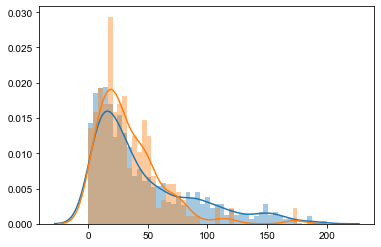

In [314]:
sns.distplot(x_lower_risk, bins=np.linspace(0, 200, 50), kde=True)
sns.distplot(x_high_risk,  bins=np.linspace(0, 200, 50), kde=True)
plt.show()

In [315]:
# sns.violinplot([x_lower_risk, x_high_risk])

In [316]:
# Kolmogorov-Smirnov
KS, P = get_ks_stat_F(F_v, 'destination_id')
KS[0,1], P[0,1]

(0.15710690590580775, 0.00016054957442102058)

In [317]:
# plot_ks_matrix(KS), plot_pval_matrix(P)

In [318]:
# Mann Whitney U test
for j in list(range(len(risk_cat))):
    print(check_MW_F(F_hi, -1, j))
    print('---')

High risk vs. Lower risk
MannwhitneyuResult(statistic=129755.0, pvalue=0.00030602881270223495)
---
High risk vs. High risk
MannwhitneyuResult(statistic=23544.5, pvalue=0.9996939801402582)
---


In [319]:
mannwhitneyu(x_lower_risk, x_high_risk, alternative='two-sided')

MannwhitneyuResult(statistic=168549.0, pvalue=0.015698194402832544)

In [320]:
kruskal(x_lower_risk, x_high_risk)

KruskalResult(statistic=5.836743502883575, pvalue=0.015694848740426145)

### Risk vs transitions

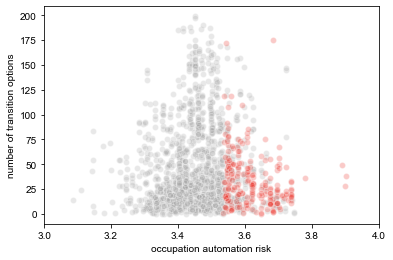

In [321]:
trans_risk = merge_risks(trans, 'origin_id', 'origin')

plt.scatter(x=data.occ_top.iloc[rows_lower_risk].risk,
            y=x_lower_risk,
            alpha=0.25, color=(0.65,.65,.65), edgecolors=[1,1,1])

plt.scatter(x=data.occ_top.iloc[rows_high_risk].risk,
            y=x_high_risk,
            alpha=0.25, color=np.array([237, 46, 36])/255, edgecolors=[1,1,1])
plt.xlabel('occupation automation risk')
plt.ylabel('number of transition options')
plt.xlim([3,4])
plt.show()

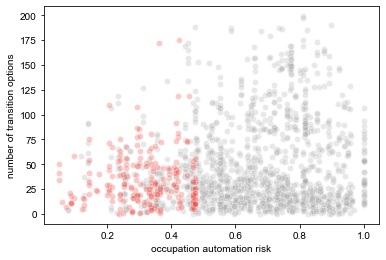

In [322]:
trans_risk = merge_risks(trans, 'origin_id', 'origin')

plt.scatter(x=data.occ_top.iloc[rows_lower_risk].prop_bottleneck_tasks,
            y=x_lower_risk,
            alpha=0.25, color=(0.65,.65,.65), edgecolors=[1,1,1])

plt.scatter(x=data.occ_top.iloc[rows_high_risk].prop_bottleneck_tasks,
            y=x_high_risk,
            alpha=0.25, color=np.array([237, 46, 36])/255, edgecolors=[1,1,1])
plt.xlabel('occupation automation risk')
plt.ylabel('number of transition options')
plt.show()

### Highly viable transitions

In [323]:
x_lower_hi = np.sum(F_hi[rows_lower_risk,:], axis=1)
x_high_hi = np.sum(F_hi[rows_high_risk,:], axis=1)

print(kruskal(x_lower_hi, x_high_hi))

# Means
print(np.round(np.mean(x_lower_hi)), np.round(np.mean(x_high_hi)))
# Difference of means
print(np.mean(x_lower_hi)/np.mean(x_high_hi))
# Means
print('---')
print(np.round(np.median(x_lower_hi)), np.round(np.median(x_high_hi)))
# Difference of medians
print(np.median(x_lower_hi)/np.median(x_high_hi))

KruskalResult(statistic=13.033690049056114, pvalue=0.0003059371430391076)
17.0 9.0
1.9311308583163471
---
7.0 6.0
1.1666666666666667


## 1.2 Similarity to desirable & viable destinations 

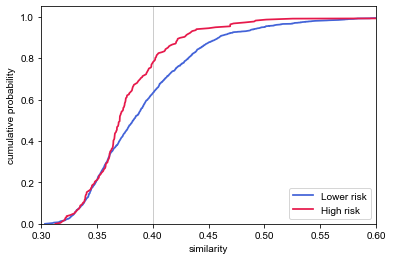

In [324]:
## Aggregate transition stats for each occupation
trans = trans_select.groupby('origin_id').mean().reset_index()

# Plot cumulative distributions
plot_cum_dist(trans, 'similarity')

sns.lineplot(x=[0.4,0.4], y=[0,1.05], color='k', linewidth=0.5)
plt.legend(loc='lower right')
plt.xlim([0.3,0.6])
plt.ylim([0,1.05])
plt.xlabel('similarity')
plt.ylabel('cumulative probability')
plt.show()


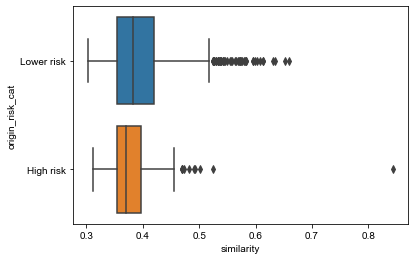

In [325]:
trans_risk = merge_risks(trans, 'origin_id', 'origin')
sns.boxplot(data=trans_risk,
            y='origin_risk_cat', x='similarity',
            order=risk_cat)
plt.show()

In [326]:
trans_risk.groupby('origin_risk_cat').agg({'similarity': 'median'})

,similarity
origin_risk_cat,
High risk,0.370310
Lower risk,0.382423


In [327]:
trans_risk.groupby('origin_risk_cat').agg({'similarity': 'mean'})

,similarity
origin_risk_cat,
High risk,0.379120
Lower risk,0.393302


### Statistical tests for differences in distributions

In [328]:
# Kolmogorov-Smirnov
KS, P = get_ks_stat_F(F_v, 'destination_id')
KS[0,1], P[0,1]

(0.15710690590580775, 0.00016054957442102058)

In [329]:
for j in list(range(len(risk_cat))):
    print(check_MW(trans, 'similarity', -1, j))
    print('---')

High risk vs. Lower risk
MannwhitneyuResult(statistic=128718.0, pvalue=0.000383845907770406)
---
High risk vs. High risk
MannwhitneyuResult(statistic=23328.0, pvalue=0.9996925273651659)
---


### Risk vs similarity of the destination

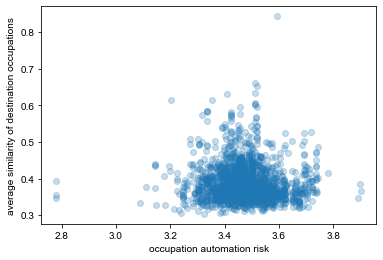

In [330]:
trans_risk = merge_risks(trans, 'origin_id', 'origin')

plt.scatter(x=trans_risk.origin_risk,
            y=trans_risk.similarity,
            alpha=0.25)
plt.xlabel('occupation automation risk')
plt.ylabel('average similarity of destination occupations')
plt.show()

In [331]:
spearmanr(trans_risk.origin_risk, trans_risk.similarity)

SpearmanrResult(correlation=-0.06444431396728253, pvalue=0.009516375087123306)

## 1.3 Automation risk at the viable & desirable destinations

In [332]:
from scipy.stats import siegelslopes, linregress, theilslopes

### Destination risk vs origin risk

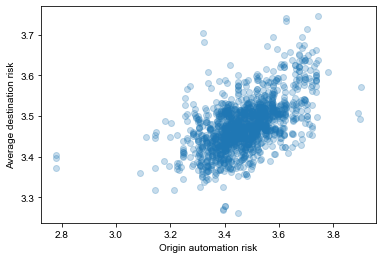

In [333]:
trans = merge_risks(trans_select, 'destination_id', 'destination')
trans = trans.groupby('origin_id').agg({'destination_risk': 'mean'}).reset_index()
trans = merge_risks(trans, 'origin_id', 'origin')

ax = plt.scatter(x=trans.origin_risk,
            y=trans.destination_risk,
            alpha=0.25)
ax.axes.set_aspect(1.5)
plt.xlabel('Origin automation risk')
plt.ylabel('Average destination risk')
plt.savefig(figure_folder + 'Neighbourhood_risk_Risk_orig_vs_dest.png', dpi=200, bbox_inches='tight', transparent=True)
plt.show()

In [334]:
spearmanr(trans.origin_risk, trans.destination_risk)

SpearmanrResult(correlation=0.5449507847794008, pvalue=8.21979832130038e-126)

In [335]:
lin_coef = linregress(trans.origin_risk, trans.destination_risk)
lin_coef

LinregressResult(slope=0.30417920474041177, intercept=2.419417916221, rvalue=0.5574865394826916, pvalue=8.674832069228993e-133, stderr=0.011268078138972803)

In [336]:
colour_map = {
#     'Low risk': np.array([41, 191, 21])/255, # green (not used)
    'Low risk': np.array([52, 146, 235])/255, # blue
    'Other': np.array([191, 191, 191])/255, # gray
    'High risk': np.array([222, 51, 9])/255, # red
}

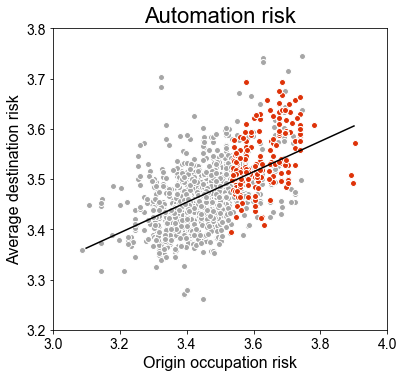

In [337]:
plt.figure(figsize=(6,6))

x_vals = [3.1, 3.9]
y_lin = [lin_coef.slope*x+lin_coef.intercept for x in x_vals]
# y_alt = [alt_coef[0]*x+alt_coef[1] for x in x_vals]

ax = plt.scatter(
    x=trans[trans.origin_risk_cat!='High risk'].origin_risk,
    y=trans[trans.origin_risk_cat!='High risk'].destination_risk,
    alpha=1, edgecolors=[1,1,1],
    color=(0.65,.65,.65)
#     color = colour_map['Low risk']
)

ax = plt.scatter(
    x=trans[trans.origin_risk_cat=='High risk'].origin_risk,
    y=trans[trans.origin_risk_cat=='High risk'].destination_risk,
    alpha=1, edgecolors=[1,1,1],
#     color=np.array([237, 46, 36])/255
    color = colour_map['High risk']
)

plt.plot(x_vals, y_lin, color='k', linewidth=1.5)
# plt.plot(x_vals, y_alt, color='k')

ax.axes.set_aspect(1.5)
plt.xlim([3, 4])
plt.ylim([3.2, 3.8])
plt.xlabel('Origin occupation risk', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Average destination risk', fontsize=16)
plt.yticks(fontsize=14)
plt.title('Automation risk', fontsize=22)
plt.savefig(figure_folder + 'Neighbourhood_risk_Risk_orig_vs_dest_Extra.png', dpi=200, bbox_inches='tight', transparent=True)
plt.savefig(figure_folder + 'Neighbourhood_risk_Risk_orig_vs_dest_Extra.svg', dpi=200, bbox_inches='tight', transparent=True)
plt.show()


In [338]:
# EXPORT to the outputs folder
trans[['origin_id', 'origin_risk', 'origin_risk_cat', 'destination_risk']].to_csv(
    outputs_folder + 'Origin_risk_VS_Destination_risk_ALL_occ.csv', index=False)


### High vs. Lower risk occupation distributions

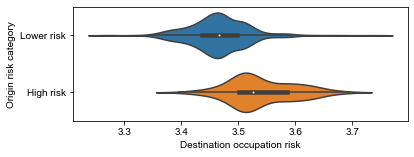

In [339]:
ax = sns.violinplot(data=trans,
            y='origin_risk_cat', x='destination_risk',
            order=risk_cat)
ax.axes.set_aspect(0.1)
plt.xlabel('Destination occupation risk')
plt.ylabel('Origin risk category')
plt.savefig(figure_folder + 'Neighbourhood_risk_Risk_categories.png', dpi=200, bbox_inches='tight', transparent=True)
plt.show()

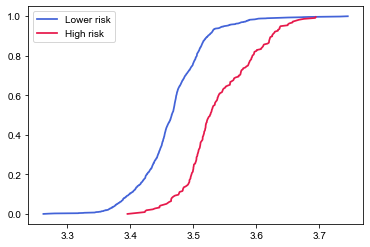

In [340]:
plot_cum_dist(trans, 'destination_risk')

In [341]:
for j in list(range(len(risk_cat))):
    print(check_MW(trans, 'destination_risk', -1, j))
    print('---')

High risk vs. Lower risk
MannwhitneyuResult(statistic=254732.0, pvalue=9.14299890245199e-59)
---
High risk vs. High risk
MannwhitneyuResult(statistic=23328.0, pvalue=0.9996925271821006)
---


In [342]:
KS, P = get_ks_stat(trans, 'destination_risk')
KS[0,1], P[0,1]

(0.5701114809531357, 2.8954837915646794e-53)

In [343]:
trans.groupby('origin_risk_cat').agg({'destination_risk':'mean'})

,destination_risk
origin_risk_cat,
High risk,3.539669
Lower risk,3.465571


In [344]:
# Number of transitions that are not in VHR
trans_not_vhr = trans_select.groupby('origin_id').agg({'is_not_vhr':'mean'}).reset_index()
trans_not_vhr = merge_risks(trans_not_vhr, 'origin_id', 'origin')
trans_not_vhr.groupby('origin_risk_cat').mean()

,origin_id,is_not_vhr,id,origin_risk,origin_prop
origin_risk_cat,,,,,
High risk,1514.736111,0.596847,1514.736111,3.620499,0.321736
Lower risk,1450.315977,0.908386,1450.315977,3.448874,0.670286


### Destination bottlenecks vs origin bottlenecks

LinregressResult(slope=0.61242398470448, intercept=0.23541268629236844, rvalue=0.7914931659027529, pvalue=0.0, stderr=0.011763920158384657)


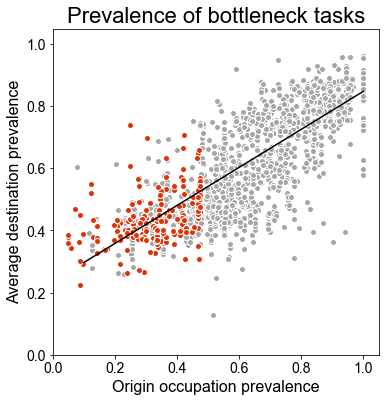

In [345]:
### Destination bottlenecks vs origin bottlenecks

trans_prop = merge_risks(trans_select, 'destination_id', 'destination')
trans_prop = trans_prop.groupby('origin_id').agg({'destination_prop': 'mean'}).reset_index()
trans_prop = merge_risks(trans_prop, 'origin_id', 'origin')

lin_coef = linregress(trans_prop.origin_prop, trans_prop.destination_prop)
print(lin_coef)

plt.figure(figsize=(6,6))

x_vals = [0.1, 1]
y_lin = [lin_coef.slope*x+lin_coef.intercept for x in x_vals]
# y_alt = [alt_coef[0]*x+alt_coef[1] for x in x_vals]

ax = plt.scatter(
    x=trans_prop[trans_prop.origin_risk_cat!='High risk'].origin_prop,
    y=trans_prop[trans_prop.origin_risk_cat!='High risk'].destination_prop,
    alpha=1,edgecolors=[1,1,1],
    color=(0.65,.65,.65))
#     color = colour_map['Low risk']
# )

ax = plt.scatter(
    x=trans_prop[trans_prop.origin_risk_cat=='High risk'].origin_prop,
    y=trans_prop[trans_prop.origin_risk_cat=='High risk'].destination_prop,
    alpha=1, edgecolors=[1,1,1],
#     color=np.array([237, 46, 36])/255
    color = colour_map['High risk']
)

plt.plot(x_vals, y_lin, color='k', linewidth=1.5)
# plt.plot(x_vals, y_alt, color='k')

ax.axes.set_aspect(1)
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])

plt.xlabel('Origin occupation prevalence', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Average destination prevalence', fontsize=16)
plt.yticks(fontsize=14)
plt.title('Prevalence of bottleneck tasks', fontsize=22)

plt.savefig(figure_folder + 'Neighbourhood_risk_Bottlenecks_orig_vs_dest_Extra.png', dpi=200, bbox_inches='tight', transparent=True)
plt.savefig(figure_folder + 'Neighbourhood_risk_Bottlenecks_orig_vs_dest_Extra.svg', dpi=200, bbox_inches='tight', transparent=True)
plt.show()


In [346]:
spearmanr(trans_prop.origin_prop, trans_prop.destination_prop)

SpearmanrResult(correlation=0.8038042791586796, pvalue=0.0)

In [347]:
# EXPORT to the outputs folder
trans_prop[['origin_id', 'origin_prop', 'origin_risk_cat', 'destination_prop']].to_csv(
    outputs_folder + 'Origin_prop_bottlenecks_VS_Destination_prop_bottlenecks_ALL_occ.csv', index=False)


# 2. Viable, desirable & safe destinations

Here, we will generally define safe as NOT "high risk" category - in order to have a fair comparison between higher risk and lower risk occupations; 

In [348]:
jj = [data.id_to_top_id[x] for x in data.occ_top[-data.occ_top.risk.isnull()].id.to_list()]

## 2.1 Number of transition options

In [349]:
## Select the relevant subset of transitions: Viable, Desirable & Safe
trans_select = transitions[transitions.is_viable_desirable & transitions.is_not_vhr]

# Use filtering matrices to account for occupations with 0 transitions 
F = filter_matrices['F_viable_desirable'] & filter_matrices['F_not_vhr'] & filter_matrices['F_not_self'] #& filter_matrices['F_safer']3 
F_hi = F & filter_matrices['F_highly_viable']

F = F[:,jj]
F_hi = F_hi[:, jj]

F.shape

(1701, 1627)

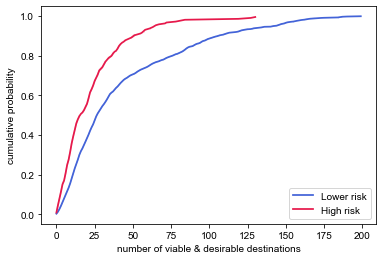

In [350]:
## Aggregate transition stats for each occupation

# # Plot cumulative distributions
plot_cum_dist_F(F)
plt.legend(loc='lower right')
plt.xlabel('number of viable & desirable destinations')
plt.ylabel('cumulative probability')
plt.show()


In [351]:
# Row # for high risk
rows_high_risk = [data.id_to_top_id[x] for x in cat_ids[1]]
# Row # for lower risk
rows_lower_risk = [data.id_to_top_id[x] for x in cat_ids[0]]

# Transitions for each risk category
x_all = np.sum(F, axis=1)
x_all_hi = np.sum(F_hi, axis=1)
x_lower_risk = np.sum(F[rows_lower_risk,:], axis=1)
x_high_risk = np.sum(F[rows_high_risk,:], axis=1)

In [352]:
# Check if there are occupations with zero transitions
print(np.sum(x_high_risk==0)/len(x_high_risk))

0.02304147465437788


In [353]:
# Means
print(np.mean(x_lower_risk), np.mean(x_high_risk))
# Difference of means
(np.mean(x_lower_risk)-np.mean(x_high_risk))/np.mean(x_high_risk)

42.778014184397165 22.161290322580644


0.9303034057006

In [354]:
# Medians
print(np.median(x_lower_risk), np.median(x_high_risk))
# Difference in medians
print((np.median(x_lower_risk)-np.median(x_high_risk))/np.median(x_high_risk))

26.0 15.0
0.7333333333333333


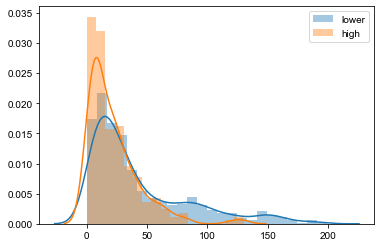

In [355]:
sns.distplot(x_lower_risk, label='lower')
sns.distplot(x_high_risk, label='high')
plt.legend()
plt.show()

In [356]:
# STORE IN THE DATAFRAME
occ_n_transitions['n_safe_viable_desirable'] = x_all
occ_n_transitions['n_high_Safe_viable_desirable'] = x_all_hi


### Statistical tests for differences in distributions

In [357]:
# Kolmogorov-Smirnov
KS, P = get_ks_stat_F(F, 'destination_id')
KS[0,1], P[0,1]

(0.2110860541883191, 8.035860288302388e-08)

In [358]:
# Mann Whitney U test
for j in list(range(len(risk_cat))):
    print(check_MW_F(F, -1, j))
    print('---')

High risk vs. Lower risk
MannwhitneyuResult(statistic=105089.0, pvalue=1.0463957289639676e-13)
---
High risk vs. High risk
MannwhitneyuResult(statistic=23544.5, pvalue=0.9996945004892462)
---


In [359]:
kruskal(x_lower_risk, x_high_risk)

KruskalResult(statistic=55.27903350363704, pvalue=1.0457815050107155e-13)

### Number of highly viable vs minimally viable transitions

In [360]:
F_hi = F & filter_matrices['F_highly_viable'][:,jj]

# Transitions for each risk category
x_all = np.sum(F_hi, axis=1)
x_lower_risk = np.sum(F_hi[rows_lower_risk,:], axis=1)
x_high_risk = np.sum(F_hi[rows_high_risk,:], axis=1)

# Means
print(np.mean(x_lower_risk), np.mean(x_high_risk))
# Difference of means
print((np.mean(x_lower_risk)-np.mean(x_high_risk))/np.mean(x_high_risk))
print('----')
# Medians
print(np.median(x_lower_risk), np.median(x_high_risk))
# Difference in medians
print((np.median(x_lower_risk)-np.median(x_high_risk))/np.median(x_high_risk))

15.839716312056737 4.645161290322581
2.409938928289992
----
7.0 2.0
2.5


In [361]:
kruskal(x_lower_risk, x_high_risk)

KruskalResult(statistic=101.09294617461079, pvalue=8.776688651269227e-24)

In [362]:
# 1/3 of high risk have no highly vible transitions
np.sum(x_high_risk==0)/len(x_high_risk)

0.2995391705069124

In [363]:
# 7% have no highly viable transitions
np.sum(x_lower_risk==0)/len(x_lower_risk)

0.07375886524822695

## 2.2 Similarity to the viable, desirable & safe destinations

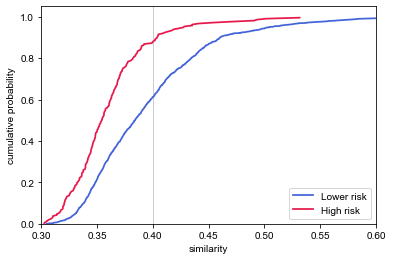

In [364]:
## Aggregate transition stats for each occupation
trans = trans_select.groupby('origin_id').mean().reset_index()

# Plot cumulative distributions
warnings.simplefilter("ignore")

for j, cat in enumerate(risk_cat):
    x = trans[trans.origin_id.isin(cat_ids[j])].similarity
    x_sorted = np.sort(x)
    p = np.array(list(range(0,len(x_sorted)))) / len(x_sorted)
    sns.lineplot(y=p, x=x_sorted, label=risk_cat[j], color=color_pal_[j], linewidth=1.75)    

sns.lineplot(x=[0.4,0.4], y=[0,1.05], color='k', linewidth=0.5)
plt.legend(loc='lower right')
plt.xlim([0.3,0.6])
plt.ylim([0,1.05])
plt.xlabel('similarity')
plt.ylabel('cumulative probability')
plt.show()


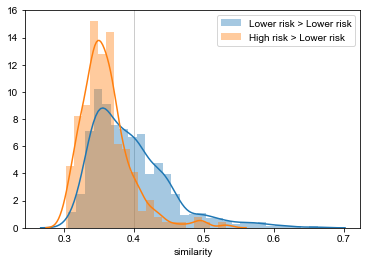

In [365]:
labels = ['Lower risk > Lower risk', 'High risk > Lower risk']
for j, cat in enumerate(risk_cat):
    x = trans[trans.origin_id.isin(cat_ids[j])].similarity
    sns.distplot(x, label=labels[j])
sns.lineplot(x=[0.4,0.4], y=[0, 18], linewidth=1, c='k')
plt.ylim([0, 16])
plt.legend()
plt.show()

In [366]:
cols = [list(np.append(list(colour_map.values())[x], 1)) for x in range(len(colour_map))]

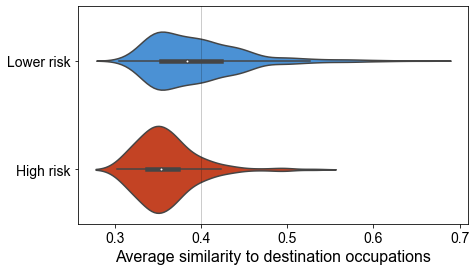

In [367]:
plt.figure(figsize=(7,4))
trans_risk = merge_risks(trans, 'origin_id', 'origin')
sns.violinplot(data=trans_risk,
            y='origin_risk_cat', x='similarity', 
               palette= [cols[2], cols[0]],
            order=[risk_cat[-1],risk_cat[0]])
sns.lineplot(x=[0.4,0.4], y=[-2, 2], linewidth=1, c='k')
plt.ylabel('', fontsize=16)
plt.xlabel('Average similarity to destination occupations', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([-0.5, 1.5])

plt.savefig(figure_folder + 'fig_kk_r8.png', dpi=200, bbox_inches='tight', transparent=True)    
plt.savefig(figure_folder + 'fig_kk_r8.svg', dpi=200, bbox_inches='tight', transparent=True)    

plt.show()

In [368]:
trans_risk[['origin_id', 'similarity', 'origin_risk_cat']].to_csv(data_folder + 'interim/fig_kk_r8.csv', index=False)

In [369]:
df_mean_sim = trans_risk.groupby('origin_risk_cat').agg({'similarity': 'mean'})
df_mean_sim

,similarity
origin_risk_cat,
High risk,0.359797
Lower risk,0.394942


In [370]:
(df_mean_sim-df_mean_sim.loc['High risk', 'similarity']) / df_mean_sim * 100

,similarity
origin_risk_cat,
High risk,0.000000
Lower risk,8.898719


### Significance tests

In [371]:
KS, P = get_ks_stat(trans, 'similarity')
KS[0,1], P[0,1]

(0.3322723778440126, 4.429049538545435e-18)

In [372]:
for j in list(range(len(risk_cat))):
    print(check_MW(trans, 'similarity', -1, j))
    print('---')

High risk vs. Lower risk
MannwhitneyuResult(statistic=86859.0, pvalue=2.182129920958735e-22)
---
High risk vs. High risk
MannwhitneyuResult(statistic=22472.0, pvalue=0.999683791183146)
---


## 2.3 Automation risk at the viable & desirable destinations << JUST CHECK

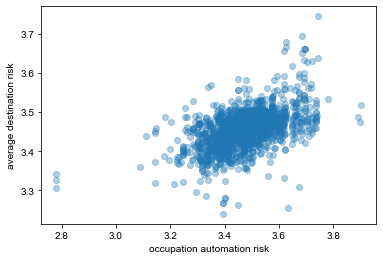

In [373]:
trans = merge_risks(trans_select, 'destination_id', 'destination')
trans = trans.groupby('origin_id').agg({'destination_risk': 'mean'}).reset_index()
trans = merge_risks(trans, 'origin_id', 'origin')

plt.scatter(x=trans.origin_risk,
            y=trans.destination_risk,
            alpha=0.35)
plt.xlabel('occupation automation risk')
plt.ylabel('average destination risk')
plt.show()

In [374]:
spearmanr(trans.origin_risk, trans.destination_risk)

SpearmanrResult(correlation=0.5050457894711499, pvalue=5.137895977352829e-105)

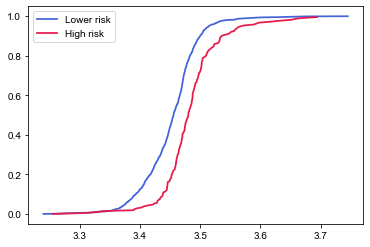

In [375]:
plot_cum_dist(trans, 'destination_risk')

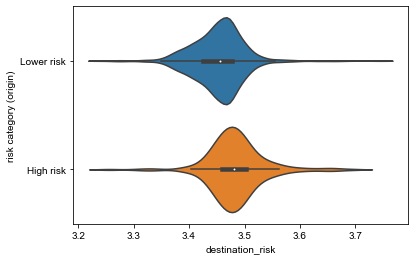

In [376]:
sns.violinplot(data=trans,
            y='origin_risk_cat', x='destination_risk',
            order=risk_cat)
plt.ylabel('risk category (origin)')
plt.show()

In [377]:
KS, P = get_ks_stat(trans, 'destination_risk')
KS[0,1], P[0,1]

(0.2961009885767462, 6.328271240363392e-15)

In [378]:
for j in list(range(len(risk_cat))):
    print(check_MW(trans, 'destination_risk', -1, j))
    print('---')

High risk vs. Lower risk
MannwhitneyuResult(statistic=206672.0, pvalue=2.2741474280491118e-20)
---
High risk vs. High risk
MannwhitneyuResult(statistic=22472.0, pvalue=0.9996837906853306)
---


# 3. Number of  *safer* destinations for each high risk occupation

Quick check with safer destinations

In [379]:
F_safer = filter_matrices['F_viable_desirable'] & filter_matrices['F_not_vhr'] & filter_matrices['F_not_self'] & filter_matrices['F_safer']
F_safer_hi = F_safer & filter_matrices['F_highly_viable']
F_safer = F_safer[:,jj]
F_safer_hi = F_safer_hi[:,jj]


In [380]:
x_high_risk_safer = np.sum(F_safer[[data.id_to_top_id[x] for x in cat_ids[1]],:], axis=1)
np.median(x_high_risk_safer)

12.0

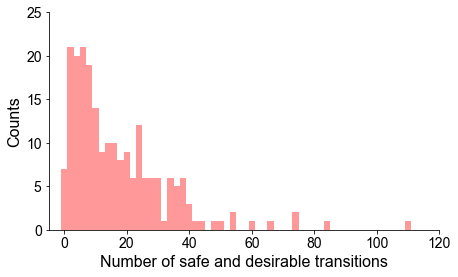

In [381]:
plt.figure(figsize=(7,4))
ax = sns.distplot(x_high_risk_safer, bins=list(range(-1,140,2)),
                  kde=False,
                 color='r')
plt.ylabel('Counts', fontsize=16)
plt.xlabel('Number of safe and desirable transitions', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks([0, 5, 10, 15, 20, 25], fontsize=14)
plt.ylim([0, 25])
plt.xlim([-5, 120])

for x in ['right', 'top']:
    right_side = ax.spines[x]
    right_side.set_visible(False)

plt.savefig(figure_folder + 'fig_kk_r9.png', dpi=200, bbox_inches='tight', transparent=True)    
plt.savefig(figure_folder + 'fig_kk_r9.svg', dpi=200, bbox_inches='tight', transparent=True)    

plt.show()


In [399]:
# for x in x_high_risk_safer:
#     print(x)

In [385]:
# Transitions for each risk category
x_all = np.sum(F_safer, axis=1)
x_lower_risk = np.sum(F_safer[rows_lower_risk,:], axis=1)
x_high_risk = np.sum(F_safer[rows_high_risk,:], axis=1)

# Means
print(np.mean(x_lower_risk), np.mean(x_high_risk))
# Difference of means
print((np.mean(x_lower_risk)-np.mean(x_high_risk))/np.mean(x_high_risk))
print('----')
# Medians
print(np.median(x_lower_risk), np.median(x_high_risk))
# Difference in medians
print((np.median(x_lower_risk)-np.median(x_high_risk))/np.median(x_high_risk))

10.753191489361702 16.677419354838708
-0.3552244948351783
----
4.0 12.0
-0.6666666666666666


In [386]:
np.sum(x_high_risk==0)/len(x_high_risk)

0.03225806451612903

In [408]:
# STORE IN THE DATAFRAME
occ_n_transitions['n_safer_viable_desirable'] = x_all

x_all_hi = np.sum(F_safer_hi, axis=1)
occ_n_transitions['n_high_Safer_viable_desirable'] = x_all_hi

In [409]:
## Add also only viable transitions
F_viable = filter_matrices['F_viable'] & filter_matrices['F_jobzone'] & filter_matrices['F_not_vhr'] & filter_matrices['F_not_self']
F_viable_hi = F_viable & filter_matrices['F_highly_viable']
F_viable = F_viable[:,jj]
F_viable_hi = F_viable_hi[:,jj]

x_viable = np.sum(F_viable, axis=1)
x_viable_hi = np.sum(F_viable_hi, axis=1)
occ_n_transitions['n_safe_viable'] = x_viable
occ_n_transitions['n_high_Safe_Viable'] = x_viable_hi

### Export!

In [410]:
df_transitions = pd.DataFrame(data={'id':cat_ids[1], 'transitions': x_high_risk_safer})
df_transitions = df_transitions.merge(data.occ_top[['id','preferred_label']])
df_transitions = df_transitions[['id','preferred_label','transitions']].sort_values('transitions')
df_transitions.to_csv(outputs_folder+'High_risk_occupations_Transition_n.csv', index=False)


In [411]:
df_transitions

,id,preferred_label,transitions
150,2054,payroll clerk,0
193,2645,amusement and recreation attendant,0
116,1627,human rights officer,0
118,1689,tourist animator,0
159,2136,motion picture film developer,0
...,...,...,...
65,1002,industrial engineer,65
77,1166,maintenance and repair engineer,73
139,1907,corporate training manager,74
211,2879,child day care centre manager,83


In [412]:
df_transitions[df_transitions.preferred_label=='hotel concierge']

,id,preferred_label,transitions
20,329,hotel concierge,18


In [413]:
occ_n_transitions_export = occ_n_transitions[-occ_n_transitions.risk.isnull()]
occ_n_transitions_export.to_csv(outputs_folder + 'occupations_number_of_transitions.csv', index=False)


In [414]:
occ_n_transitions_export[occ_n_transitions_export.preferred_label.str.contains('concierge')].iloc[0]

id                                                                             329
concept_uri                      http://data.europa.eu/esco/occupation/1ae8d28e...
preferred_label                                                    hotel concierge
isco_level_4                                                                  4229
onet_code                                                               39-6012.00
onet_title                                                              concierges
risk                                                                       3.90184
prop_bottleneck_tasks                                                     0.261623
prop_phys_bottleneck_tasks                                                0.201633
risk_std                                                                   0.26064
bottleneck_quartile                                                              0
risk_quartile                                                                    3
risk

In [415]:
(occ_n_transitions_export.n_high_Safer_viable_desirable > occ_n_transitions_export.n_safer_viable_desirable).sum()

0

In [416]:
# occ[(occ.risk_cat_label=='High risk')]

In [417]:
from scipy.stats import percentileofscore
print(percentileofscore(occ_n_transitions_export.employment_count.to_list(), 56870.4))

89.920098340504


/Users/karliskanders/opt/miniconda3/envs/career_causeways_test/lib/python3.6/site-packages/scipy/stats/stats.py:1942: RuntimeWarning:

invalid value encountered in less

/Users/karliskanders/opt/miniconda3/envs/career_causeways_test/lib/python3.6/site-packages/scipy/stats/stats.py:1943: RuntimeWarning:

invalid value encountered in less_equal



# 4. COVID-19

Do a check of how many transitions for the very high risk occupations are in above-median vs. below-median COVID occupations. 

In [131]:
vhr_occ = data.occ_top[-data.occ_top.risk.isnull() & (data.occ_top.risk_cat_label=='High risk')].id.to_list()
len(vhr_occ)

217

In [132]:
def merge_covid(base_df, id_col, risk_col_label):
    """
    Add risk info to the dataframe
    """
    trans_risk = base_df.merge(data.occ_top[['id','covid_score']],
                               left_on=id_col, right_on='id', how='left').rename(
        columns={
            'covid_score': risk_col_label+'_covid_score',
        })    
    return trans_risk

### COVID and risk

In [133]:
occ = data.occ_top[-data.occ_top.risk.isnull()]
# occ.info()

In [134]:
occ.groupby('risk_cat_label').agg({'covid_score':'median'})

,covid_score
risk_cat_label,
High risk,0.429146
Lower risk,0.633553


In [135]:
spearmanr(occ[-occ.covid_score.isnull()].covid_score, occ[-occ.covid_score.isnull()].risk)

SpearmanrResult(correlation=-0.287814981167184, pvalue=1.1469668887249004e-31)

### COVID and transitions

In [136]:
trans_select = transitions[transitions.is_viable_desirable & 
                           transitions.is_safer & transitions.is_not_vhr & 
                           transitions.origin_id.isin(vhr_occ)]
trans_covid = merge_covid(trans_select, 'origin_id', 'origin')
trans_covid = merge_covid(trans_covid, 'destination_id', 'destination')

In [217]:
covid_tol = 0.0

trans_covid['covid_delta'] = trans_covid['destination_covid_score'] - trans_covid['origin_covid_score']
trans_covid['is_less_covid'] = trans_covid['covid_delta'] < covid_tol
trans_covid['is_more_covid'] = trans_covid['covid_delta'] >= covid_tol
trans_covid['unknown'] = trans_covid['covid_delta'].isnull()
len(trans_covid[trans_covid.is_less_covid]) / len(trans_covid)

0.45371649626968774

In [218]:
# trans_covid.origin_covid_score.isnull().sum()

In [219]:
# occ.covid_score.std(), occ[occ.id.isin(vhr_occ)].covid_score.std()

### Sankey diagram

In [220]:
import plotly.graph_objects as go

In [221]:
sales_services_id = data.occ_top[data.occ_top.level_1==2].id.to_list()
bus_admin_id = data.occ_top[data.occ_top.level_1==1].id.to_list()

tr_sales_services = trans_covid[trans_covid.origin_id.isin(
    sales_services_id
)]

In [223]:
np.sum(tr_sales_services['is_less_covid']==False)

298

In [224]:
len(tr_sales_services)

538

In [238]:
tr_2 = tr_sales_services[tr_sales_services.destination_id.isin(sales_services_id) &
                         (tr_sales_services.origin_covid_score.isnull()==False) &
                         (tr_sales_services.destination_covid_score.isnull()==False)]
tr_3 = tr_sales_services[tr_sales_services.destination_id.isin(bus_admin_id) &
                         (tr_sales_services.origin_covid_score.isnull()==False) &
                         (tr_sales_services.destination_covid_score.isnull()==False)]
tr_4 = tr_sales_services[
    (tr_sales_services.destination_id.isin(sales_services_id)==False) &
    (tr_sales_services.destination_id.isin(bus_admin_id)==False) & 
    (tr_sales_services.origin_covid_score.isnull()==False)  &
                         (tr_sales_services.destination_covid_score.isnull()==False)
                        ]

n_0_1 =  len(tr_2)
n_0_2 =  len(tr_3)
n_0_5 =  len(tr_4)

n_1_3 =  len(tr_2[tr_2.is_less_covid])
n_1_4 = len(tr_2[tr_2.is_more_covid])

n_2_3 =  len(tr_3[tr_3.is_less_covid])
n_2_4 = len(tr_3[tr_3.is_more_covid])

n_5_3 = len(tr_4[tr_4.is_less_covid])
n_5_4 = len(tr_4[tr_4.is_more_covid])

In [276]:
n_0_1+n_0_2+n_0_5

480

In [280]:
tr__ = tr_sales_services[
                         (tr_sales_services.origin_covid_score.isnull()==False) &
                         (tr_sales_services.destination_covid_score.isnull()==False)]
len(tr__.origin_id.unique())

42

In [239]:
print(n_0_1 / (n_0_1+n_0_2+n_0_5))
print(n_0_2 / (n_0_1+n_0_2+n_0_5))
n_0_5 / (n_0_1+n_0_2+n_0_5)

0.6416666666666667
0.2708333333333333


0.0875

In [288]:
# data.isco_titles[data.isco_titles.level]

In [284]:
n_1_3 / (n_1_3 + n_1_4)

0.4318181818181818

In [282]:
(n_5_4+n_2_4+n_1_4) / (n_0_1+n_0_2+n_0_5)

0.5

In [242]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["Sales and services", #1
               "Sales and services", #2
               "Business and administration", #3
               "Smaller impact from COVID-19", #4
               "Same or larger impact from COVID-19", #5
                "Other sectors"], #6
      color = "blue"
    ),
    link = dict(
      source = [0, 0, 0, 1, 1, 2, 2, 5, 5], # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = [1, 2, 5, 3, 4, 3, 4, 3, 4],
      value = [n_0_1,
               n_0_2, n_0_5,
               n_1_3, n_1_4, n_2_3, n_2_4, n_5_3, n_5_4]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.write_image(figure_folder + 'fig_covidbox2.svg')
fig.show()

In [270]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["Sales and services", #1
               "Sales and services (safer)", #2
               "Sales and services (less safe)", #3
               "Business & admin (safer)", #4
               "Business & admin (less safe)", #5
                "Other sectors (safer)",
               "Other sectors (less safe)"], #6
      color = ["blue", "green", "red", "green", "red", "green", "red"]
    ),
    link = dict(
      source = [0, 0, 0, 0, 0, 0, 0], # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = [1, 2, 3, 4, 5, 6, 7],
      value = [n_1_3, n_1_4, n_2_3, n_2_4, n_5_3, n_5_4]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10, width=700)
fig.write_image(figure_folder + 'fig_covidbox2.svg')
fig.show()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
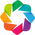

In [249]:
import holoviews as hv
from holoviews import opts, dim
hv.extension('bokeh')

In [268]:
# %%opts Sankey (cmap='Category10' edge_color='Country' edge_line_width=0 node_alpha=1.0)
# %%opts Sankey [node_sort=False label_position='left' bgcolor="snow" node_width=40 node_sort=False ]
# %%opts Sankey [width=900 height=800 title="Population Migration between New Zealand and European Countries"]
# %%opts Sankey [margin=0 padding=0]

sankey = hv.Sankey([
    ['A', 'X', 2],
    ['A', 'Y', 7],
    ['A', 'Z', 6],
    ['B', 'X', 2],
    ['B', 'Y', 9],
    ['B', 'Z', 123]]
)
sankey.opts(width=600, height=400, node_sort=False, node_width=60)

:Sankey   [start,end]   (Value)